# Sheet 8

In [223]:
import os
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
 

## 1) Anomaly detection for Autoencoders

In [224]:
# load data
X_train = np.load( "data06/toptagging-short/x_train_short.npy")
y_train = np.load( "data06/toptagging-short/y_train_short.npy")
X_test = np.load( "data06/toptagging-short/x_test_short.npy")
y_test = np.load( "data06/toptagging-short/y_test_short.npy")
X_val = np.load( "data06/toptagging-short/x_val_short.npy")
y_val = np.load( "data06/toptagging-short/y_val_short.npy")

print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


In [225]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)
    
    return z_out

In [226]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


(a)

In [227]:
# TODO: Construct autoencoder
class Autoencoder(nn.Module):
    """Some Information about MyModule"""
    def __init__( self, data_dim, hiddenlayer_size, bottleneck_size ):
        super( Autoencoder, self ).__init__()
                
        self.enc_layer1 = nn.Linear( data_dim, hiddenlayer_size )
        self.enc_relu_1 = nn.ReLU()
        self.enc_layer2 = nn.Linear( hiddenlayer_size, hiddenlayer_size )
        self.enc_relu_2 = nn.ReLU()
        self.enc_layer3 = nn.Linear( hiddenlayer_size, bottleneck_size )
        
        self.dec_layer1 = nn.Linear( bottleneck_size, hiddenlayer_size )
        self.dec_relu_1 = nn.ReLU()
        self.dec_layer2 = nn.Linear( hiddenlayer_size, hiddenlayer_size )
        self.dec_relu_2 = nn.ReLU()
        self.dec_layer3 = nn.Linear( hiddenlayer_size, data_dim )

        
    def forward( self, batch ):

        x = self.encode( batch )
        x = self.decode( x )

        return x
    
    def encode( self, batch ):
        
        x = self.enc_layer1( batch )
        x = self.enc_relu_1( x )
        x = self.enc_layer2( x )
        x = self.enc_relu_2( x )
        x = self.enc_layer3( x )
        
        return x
    
    def decode( self, batch ):
        
        x = self.dec_layer1( batch )
        x = self.dec_relu_1( x )
        x = self.dec_layer2( x )
        x = self.dec_relu_2( x )
        x = self.dec_layer3( x )

        return x

(b)

In [228]:
# TODO: Train autoencoder
from tqdm import tqdm

In [229]:
class mlp_data( torch.utils.data.Dataset ):
    
    def __init__( self, imgs, labels ):
        self.imgs = imgs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

In [230]:
z_train_flattened = z_train.reshape( (z_train.shape[0],-1) )
z_test_flattened = z_test.reshape( (z_test.shape[0],-1) )
z_val_flattened = z_val.reshape( (z_val.shape[0],-1) )

z_train_torch = torch.Tensor(z_train_flattened).float()
z_test_torch = torch.Tensor(z_test_flattened).float()
z_val_torch = torch.Tensor(z_val_flattened).float()

# create datasets with only qcd and top jets where qcd is 0 and top is 1
qcd_jet_train = z_train_torch[y_train == 0]
qcd_jet_test = z_test_torch[y_test == 0]
qcd_jet_val = z_val_torch[y_val == 0]

top_jet_train = z_train_torch[y_train == 1]
top_jet_test = z_test_torch[y_test == 1]
top_jet_val = z_val_torch[y_val == 1]

train_cnn_qcd = mlp_data(qcd_jet_train, torch.zeros(qcd_jet_train.shape[0]).unsqueeze(-1))
test_cnn_qcd = mlp_data(qcd_jet_test, torch.zeros(qcd_jet_test.shape[0]).unsqueeze(-1))
val_cnn_qcd = mlp_data(qcd_jet_val, torch.zeros(qcd_jet_val.shape[0]).unsqueeze(-1))

trn_dataloader = torch.utils.data.DataLoader( train_cnn_qcd, batch_size=64, shuffle=True )
tst_dataloader = torch.utils.data.DataLoader( test_cnn_qcd, batch_size=64, shuffle=True )
val_dataloader = torch.utils.data.DataLoader( val_cnn_qcd, batch_size=64, shuffle=True )

In [231]:
print(top_jet_train.shape)

torch.Size([15040, 1600])


In [232]:
def batch_loss(model, loss_fn, x):
    pred = model(x)
    loss = loss_fn(pred, x)
    return loss

In [233]:
def train_epoch(model, dataloader, loss_fn, losses, batch_loss_fn, optimizer):
    for x, y in dataloader:
        optimizer.zero_grad()
        loss = batch_loss_fn(model, loss_fn, x)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [234]:
def val_epoch(model, dataloader, loss_fn, losses, batch_loss_fn):
    losses_epoch = []
    with torch.no_grad():
        for x, y in dataloader:
            loss = batch_loss_fn(model, loss_fn, x)
            losses_epoch.append(loss.item())
    losses.append(np.mean(losses_epoch))
    return losses

In [235]:
n_epochs = 10
loss_fn = nn.MSELoss()

model = Autoencoder(1600, 400, 20)

model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {model_params:d} trainable parameters")
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
for epoch in tqdm(range(n_epochs)):
    train_losses = train_epoch(model, trn_dataloader, loss_fn, train_losses, batch_loss, optimizer)
    
    val_losses = val_epoch(model, val_dataloader, loss_fn, val_losses, batch_loss)
    
    if epoch%1==0:
        print(f"{epoch} / {n_epochs}")
        print(f"train loss: {train_losses[-1]:.6f}")
        print(f"val loss: {val_losses[-1]:.6f}")

Model has 1619220 trainable parameters


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:17<02:33, 17.04s/it]

0 / 10
train loss: 0.000082
val loss: 0.000079


 20%|██        | 2/10 [00:38<02:37, 19.64s/it]

1 / 10
train loss: 0.000038
val loss: 0.000046


 30%|███       | 3/10 [00:56<02:10, 18.68s/it]

2 / 10
train loss: 0.000036
val loss: 0.000036


 40%|████      | 4/10 [01:27<02:22, 23.81s/it]

3 / 10
train loss: 0.000037
val loss: 0.000031


 50%|█████     | 5/10 [02:01<02:16, 27.24s/it]

4 / 10
train loss: 0.000028
val loss: 0.000028


 60%|██████    | 6/10 [02:29<01:51, 27.75s/it]

5 / 10
train loss: 0.000023
val loss: 0.000026


 70%|███████   | 7/10 [03:02<01:27, 29.32s/it]

6 / 10
train loss: 0.000030
val loss: 0.000025


 80%|████████  | 8/10 [03:43<01:05, 33.00s/it]

7 / 10
train loss: 0.000027
val loss: 0.000024


 90%|█████████ | 9/10 [04:14<00:32, 32.55s/it]

8 / 10
train loss: 0.000024
val loss: 0.000023


100%|██████████| 10/10 [04:46<00:00, 28.66s/it]

9 / 10
train loss: 0.000018
val loss: 0.000022


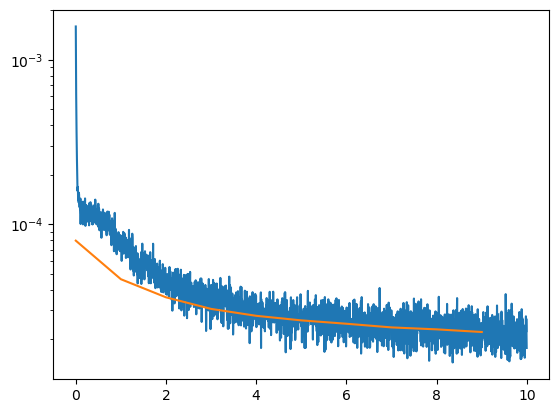

In [236]:
plt.plot(np.arange(len(train_losses)) / len(trn_dataloader), train_losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.yscale("log")
plt.show()

C)

In [237]:
# TODO: Visualize original vs reconstructed QCD and top jets

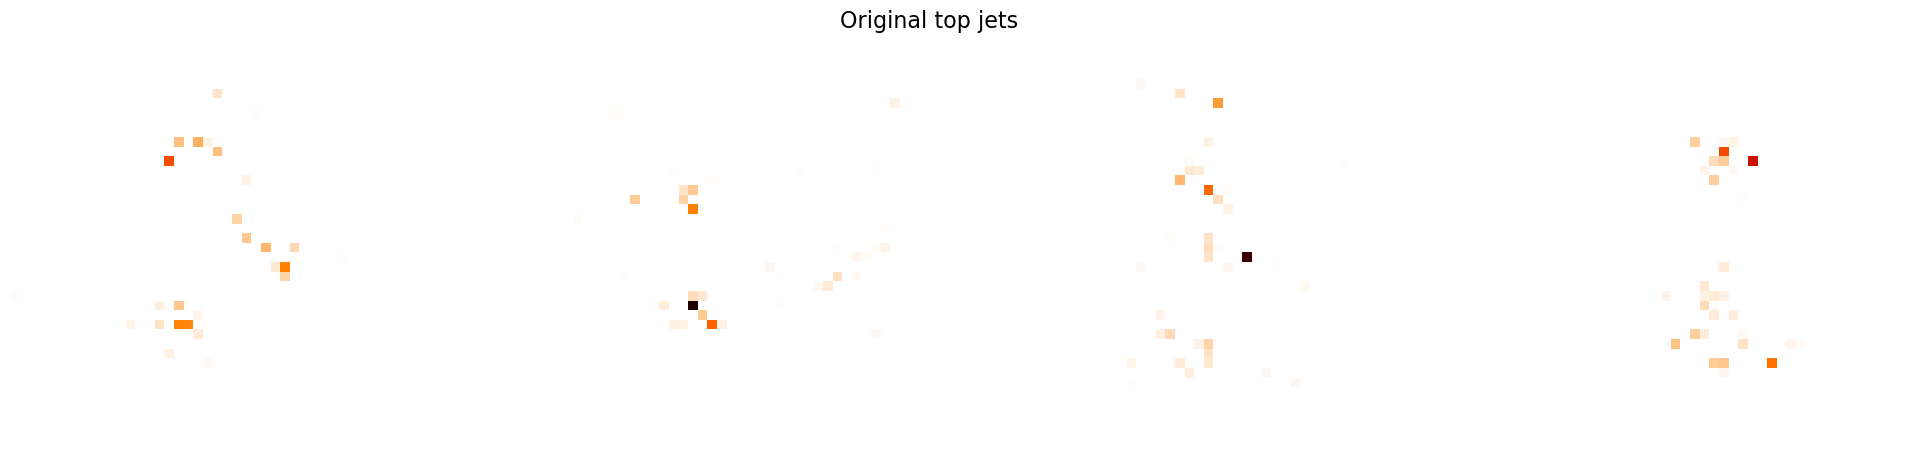

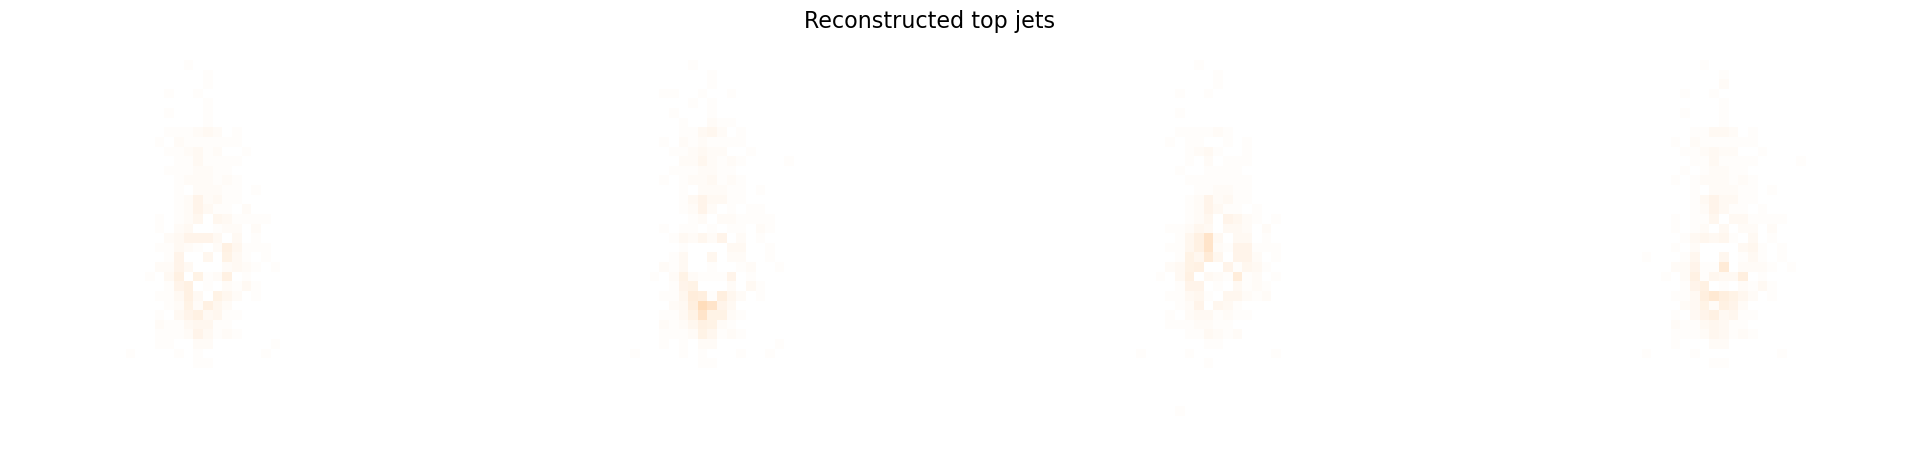

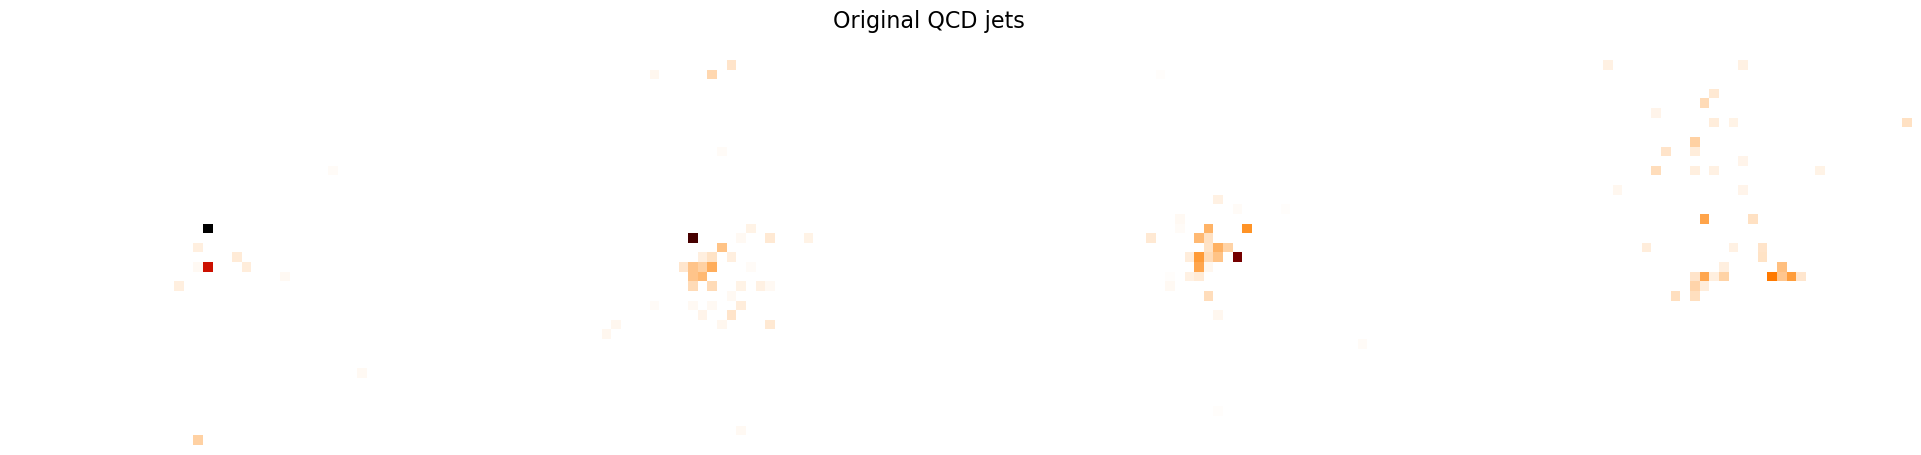

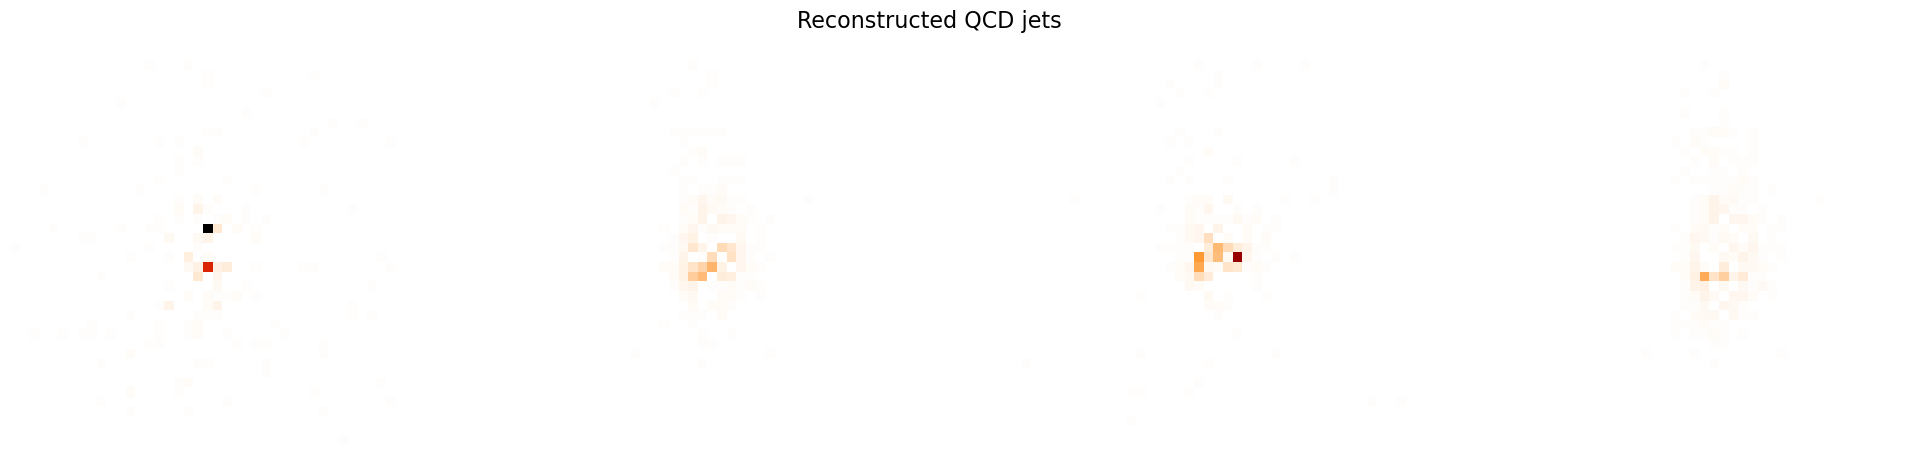

In [238]:
all_images = np.concatenate([top_jet_test, model(torch.tensor(top_jet_test).float()).detach().numpy()])
vmin, vmax = all_images.min(), 0.4
def plot_images( images, n_images, title, vmin, vmax ):
    fig, axs = plt.subplots(1, n_images, figsize=(25, 5))
    for i in range(n_images):
        axs[i].imshow(images[i].reshape(40,40), cmap="gist_heat_r", vmin=vmin, vmax=vmax)
        axs[i].axis("off")
    fig.suptitle(title, fontsize=16)
    plt.show()

plot_images(top_jet_test, 4, "Original top jets", 0, vmax)
plot_images(model(torch.tensor(top_jet_test).float()).detach().numpy(), 4, "Reconstructed top jets", 0, vmax)
plot_images(qcd_jet_test, 4, "Original QCD jets", 0, vmax)
plot_images(model(torch.tensor(qcd_jet_test).float()).detach().numpy(), 4, "Reconstructed QCD jets", 0, vmax)


The reconstructed QCD jets show good agreement to the original QCD jets. However, the MLP could not really learn the structure of the top jet, since it was not trained on the whole dataset, but only on background (QCD).

d)

In [239]:
# TODO: Visualize pixel-wise MSE, plot ROC

In [240]:
print(len(top_jet_test)) # full length of top_jet_test

14920


Text(0.5, 0.98, 'Pixel-wise MSE')

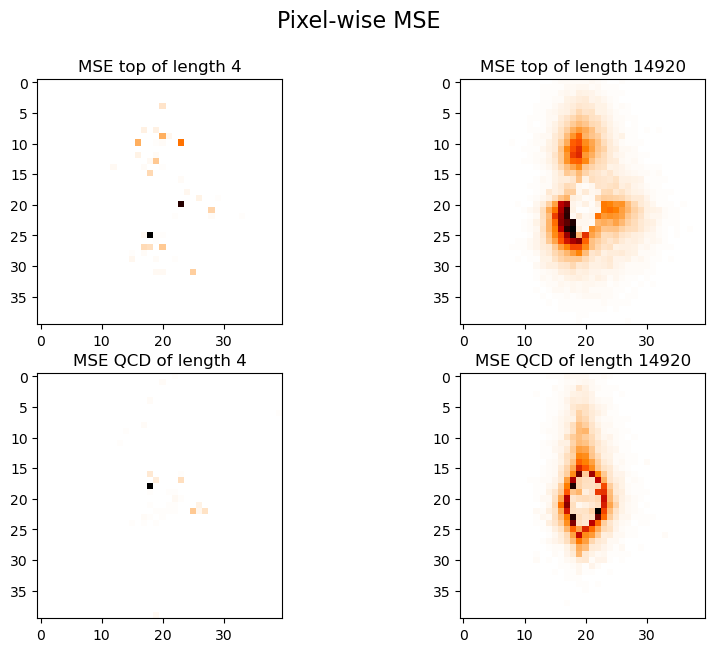

In [241]:

fig, axs = plt.subplots(2,2, figsize=(10,7))

length  = [4,len(top_jet_test)]
for i,j in enumerate(length):
    
    mse_top =np.square(top_jet_test[:j] - model(torch.tensor(top_jet_test).float())[:j].detach().numpy()).mean(axis=0)
    mse_qcd =np.square(qcd_jet_test[:j] - model(torch.tensor(qcd_jet_test).float())[:j].detach().numpy()).mean(axis=0)
    axs[0][i].imshow(mse_top.reshape(40,40), cmap="gist_heat_r")
    axs[0][i].set_title(f"MSE top of length {j}")
    axs[1][i].imshow(mse_qcd.reshape(40,40), cmap="gist_heat_r")
    axs[1][i].set_title(f"MSE QCD of length {j}")

#plt.hist(mse_top, bins=40, label="MSE top", alpha=0.5, range=(0,0.001))
#plt.hist(mse_qcd, bins=40, label="MSE QCD", alpha=0.5, range=(0,0.001))
#plt.legend()

fig.suptitle("Pixel-wise MSE", fontsize=16)


One sees that the MSE for the Top Jets are higher than for QCD, which makes sense, since the model does not know what the structure of the tops are

In [242]:

import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

from sklearn.metrics import roc_curve, roc_auc_score

def closest_point(array, tpr_p=0.3):
    dist = ((array-tpr_p)**2)
    return np.argmin(dist)

# calculate the MSE for all top and qcd jets image- wise on the test data set

mse_top =np.square(top_jet_test - model(torch.tensor(top_jet_test).float()).detach().numpy()).mean(axis=1)
mse_qcd =np.square(qcd_jet_test - model(torch.tensor(qcd_jet_test).float()).detach().numpy()).mean(axis=1)
mse_pred = np.concatenate([mse_top, mse_qcd])
print(mse_top.shape)

mse_top_labels = np.ones(mse_top.shape[0])
mse_qcd_labels = np.zeros(mse_qcd.shape[0])
mse_labels = np.concatenate([mse_top_labels, mse_qcd_labels])

torch.Size([14920])


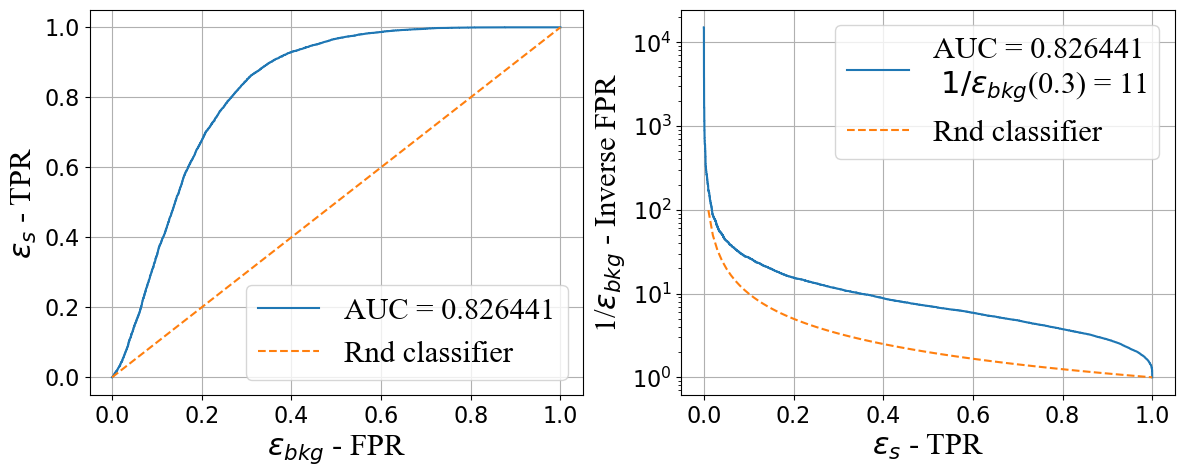

In [243]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve(mse_labels, mse_pred)
auc_score = roc_auc_score(mse_labels, mse_pred)
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.6f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.6f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR', fontproperties=axislabelfont)
ax[0].set_ylabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)

ax[1].set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
for i in range(len(ax)):
    ax[i].legend(prop=axislabelfont)
    ax[i].tick_params(labelsize=axisfontsize)
    ax[i].grid('on')

(e)

In [244]:
class cnn_data( torch.utils.data.Dataset ):
    
    def __init__( self, imgs, labels ):
        self.imgs = imgs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

In [245]:
# create dataloaders with dim (64, 1, 40, 40)

z_train_torch = torch.Tensor(z_train).float()
z_test_torch = torch.Tensor(z_test).float()
z_val_torch = torch.Tensor(z_val).float()

# create datasets with only qcd and top jets where qcd is 0 and top is 1
qcd_jet_train = z_train_torch[y_train == 0]
qcd_jet_test = z_test_torch[y_test == 0]
qcd_jet_val = z_val_torch[y_val == 0]

top_jet_train = z_train_torch[y_train == 1]
top_jet_test = z_test_torch[y_test == 1]
top_jet_val = z_val_torch[y_val == 1]

train_cnn_qcd = cnn_data(qcd_jet_train, torch.zeros(qcd_jet_train.shape[0]).unsqueeze(-1))
test_cnn_qcd = cnn_data(qcd_jet_test, torch.zeros(qcd_jet_test.shape[0]).unsqueeze(-1))
val_cnn_qcd = cnn_data(qcd_jet_val, torch.zeros(qcd_jet_val.shape[0]).unsqueeze(-1))

trn_dataloader = torch.utils.data.DataLoader( train_cnn_qcd, batch_size=64, shuffle=True )
tst_dataloader = torch.utils.data.DataLoader( test_cnn_qcd, batch_size=64, shuffle=True )
val_dataloader = torch.utils.data.DataLoader( val_cnn_qcd, batch_size=64, shuffle=True )

In [246]:
x,y = next(iter(trn_dataloader))
print(x.shape, y.shape)
print(z_train_torch.shape)

torch.Size([64, 1, 40, 40]) torch.Size([64, 1])
torch.Size([30000, 1, 40, 40])


In [247]:
# TODO: Repeat everything for CNN
class CNN2(nn.Module):
    """Some Information about MyModule"""
    def __init__(self):
        super(CNN2, self).__init__()
        lin_dim = 32*10*10 # dimension after 2x (1/16) maxpooling and 64 feature maps of a 40x40 image
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2,1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(lin_dim, 20)
        )

        self.decoder = nn.Sequential(
            nn.Linear(20, lin_dim),
            nn.Unflatten(1, (32, 10, 10)),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, 2, 1,1 ),
            nn.ReLU()
        
        )
        

    def forward(self, batch):
        x = self.encoder(batch)
        x = self.decoder(x)
        return x
    

In [248]:
class Autoencoder_CNN(nn.Module):
    def __init__(self):
        super(Autoencoder_CNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [249]:
def batch_loss2(model, loss_fn, x):
    pred = model(x)
    loss = loss_fn(pred, x)
    return loss

In [250]:
def train_epoch2(model, dataloader, loss_fn, losses, batch_loss_fn, optimizer):
    for x, y in dataloader:
        optimizer.zero_grad()
        loss = batch_loss_fn(model, loss_fn, x)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [251]:
def val_epoch2(model, dataloader, loss_fn, losses, batch_loss_fn):
    losses_epoch = []
    with torch.no_grad():
        for x, y in dataloader:
            loss = batch_loss_fn(model, loss_fn, x)
            losses_epoch.append(loss.item())
    losses.append(np.mean(losses_epoch))
    return losses

In [252]:

n_epochs = 20
loss_fn = nn.MSELoss()

model2 = Autoencoder_CNN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
for epoch in tqdm(range(n_epochs)):
    train_losses = train_epoch2(model2, trn_dataloader, loss_fn, train_losses, batch_loss2, optimizer)
    
    val_losses = val_epoch2(model2, val_dataloader, loss_fn, val_losses, batch_loss2)
    #plt.plot(np.arange(len(train_losses)) / len(trn_dataloader), train_losses)
    #plt.show()
    if epoch%1==0:
        print(f"{epoch} / {n_epochs}")
        print(f"train loss: {train_losses[-1]:.9f}")
        print(f"val loss: {val_losses[-1]:.9f}")
        

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:28<09:01, 28.50s/it]

0 / 20
train loss: 0.000313009
val loss: 0.000313010


 10%|█         | 2/20 [00:53<07:52, 26.26s/it]

1 / 20
train loss: 0.000178050
val loss: 0.000155710


 15%|█▌        | 3/20 [01:27<08:29, 29.98s/it]

2 / 20
train loss: 0.000113716
val loss: 0.000135571


 20%|██        | 4/20 [02:08<09:09, 34.34s/it]

3 / 20
train loss: 0.000155874
val loss: 0.000134360


 25%|██▌       | 5/20 [02:38<08:09, 32.67s/it]

4 / 20
train loss: 0.000122609
val loss: 0.000133904


 30%|███       | 6/20 [03:09<07:28, 32.00s/it]

5 / 20
train loss: 0.000112712
val loss: 0.000133685


 35%|███▌      | 7/20 [03:38<06:43, 31.03s/it]

6 / 20
train loss: 0.000123939
val loss: 0.000133550


 40%|████      | 8/20 [04:06<06:03, 30.30s/it]

7 / 20
train loss: 0.000125436
val loss: 0.000133479


 45%|████▌     | 9/20 [04:30<05:10, 28.26s/it]

8 / 20
train loss: 0.000119128
val loss: 0.000133415


 50%|█████     | 10/20 [04:56<04:36, 27.61s/it]

9 / 20
train loss: 0.000155998
val loss: 0.000133385


 55%|█████▌    | 11/20 [05:25<04:10, 27.88s/it]

10 / 20
train loss: 0.000099622
val loss: 0.000133352


 60%|██████    | 12/20 [05:55<03:48, 28.57s/it]

11 / 20
train loss: 0.000119953
val loss: 0.000133336


 65%|██████▌   | 13/20 [06:20<03:12, 27.56s/it]

12 / 20
train loss: 0.000132119
val loss: 0.000133316


 70%|███████   | 14/20 [06:48<02:46, 27.80s/it]

13 / 20
train loss: 0.000150534
val loss: 0.000133308


 75%|███████▌  | 15/20 [07:17<02:19, 27.89s/it]

14 / 20
train loss: 0.000124472
val loss: 0.000133297


 80%|████████  | 16/20 [07:43<01:49, 27.49s/it]

15 / 20
train loss: 0.000111937
val loss: 0.000133290


 85%|████████▌ | 17/20 [08:09<01:20, 26.98s/it]

16 / 20
train loss: 0.000109065
val loss: 0.000133288


 90%|█████████ | 18/20 [08:31<00:50, 25.40s/it]

17 / 20
train loss: 0.000112347
val loss: 0.000133277


 95%|█████████▌| 19/20 [08:53<00:24, 24.35s/it]

18 / 20
train loss: 0.000123631
val loss: 0.000133272


100%|██████████| 20/20 [09:14<00:00, 27.74s/it]

19 / 20
train loss: 0.000129910
val loss: 0.000133271


In [253]:
print(val_losses)

[0.00031300964435578975, 0.00015570974731828145, 0.00013557062304678653, 0.0001343598254027558, 0.00013390398099199474, 0.00013368467297312286, 0.00013354974716440237, 0.00013347851203015875, 0.00013341533453605525, 0.00013338502189860497, 0.00013335240097969885, 0.0001333357240341241, 0.00013331644013869182, 0.0001333076571564054, 0.0001332974026599833, 0.00013328954298384035, 0.0001332882439034612, 0.00013327687715135919, 0.00013327218512453311, 0.00013327137015289132]


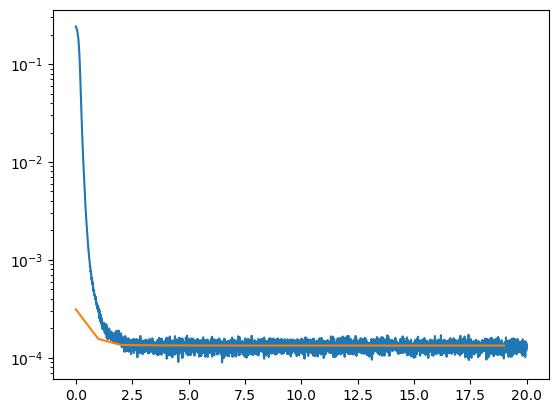

In [254]:
plt.plot(np.arange(len(train_losses)) / len(trn_dataloader), train_losses)
plt.plot( val_losses)
plt.yscale("log")

In [255]:

print(top_jet_test[0].squeeze(0).shape)

torch.Size([40, 40])


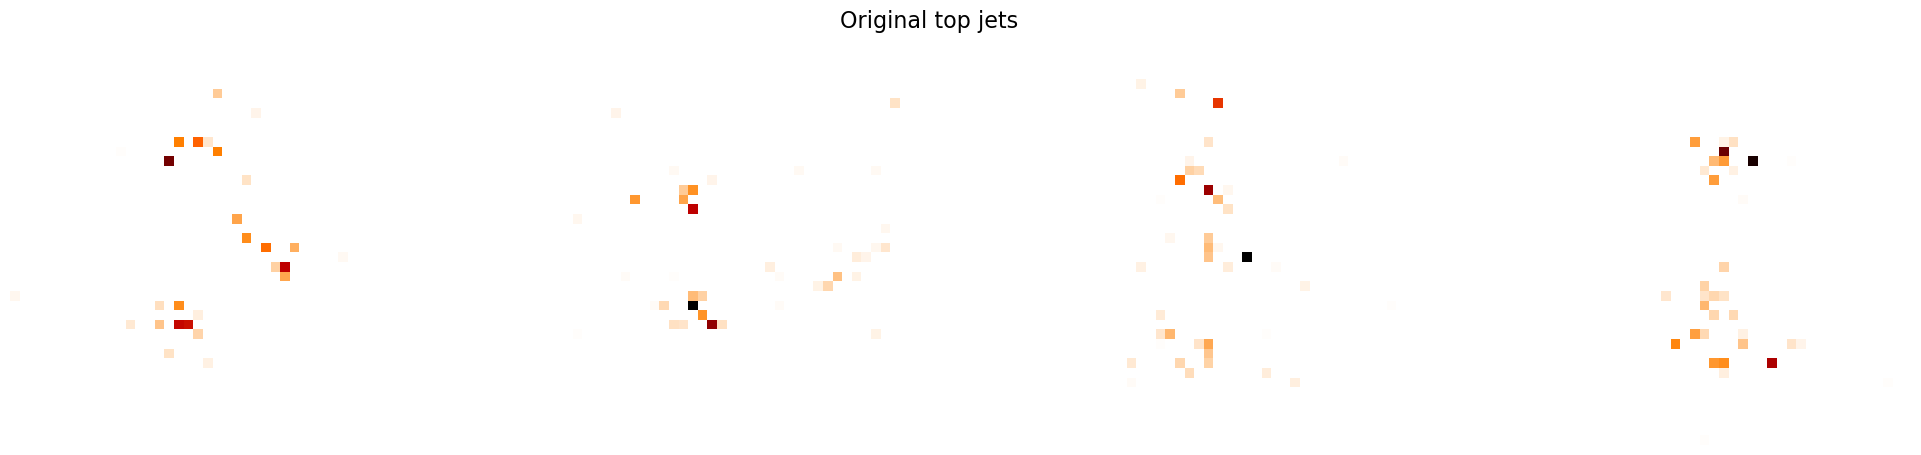

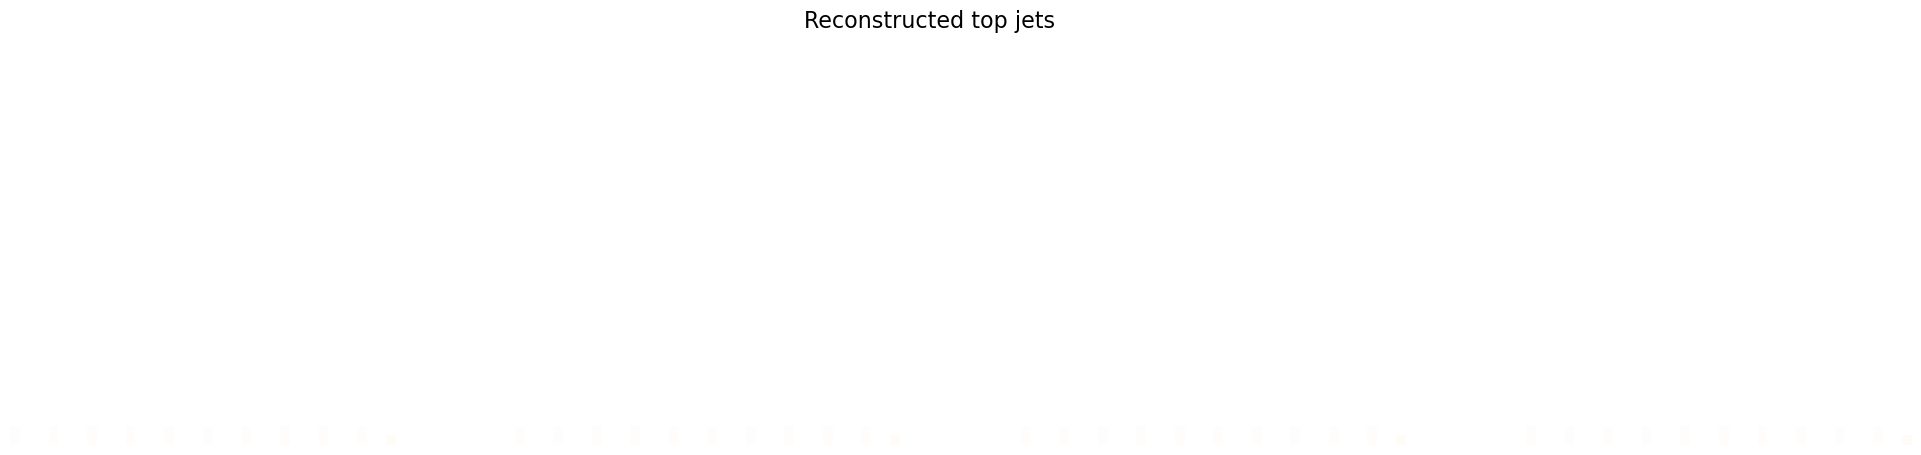

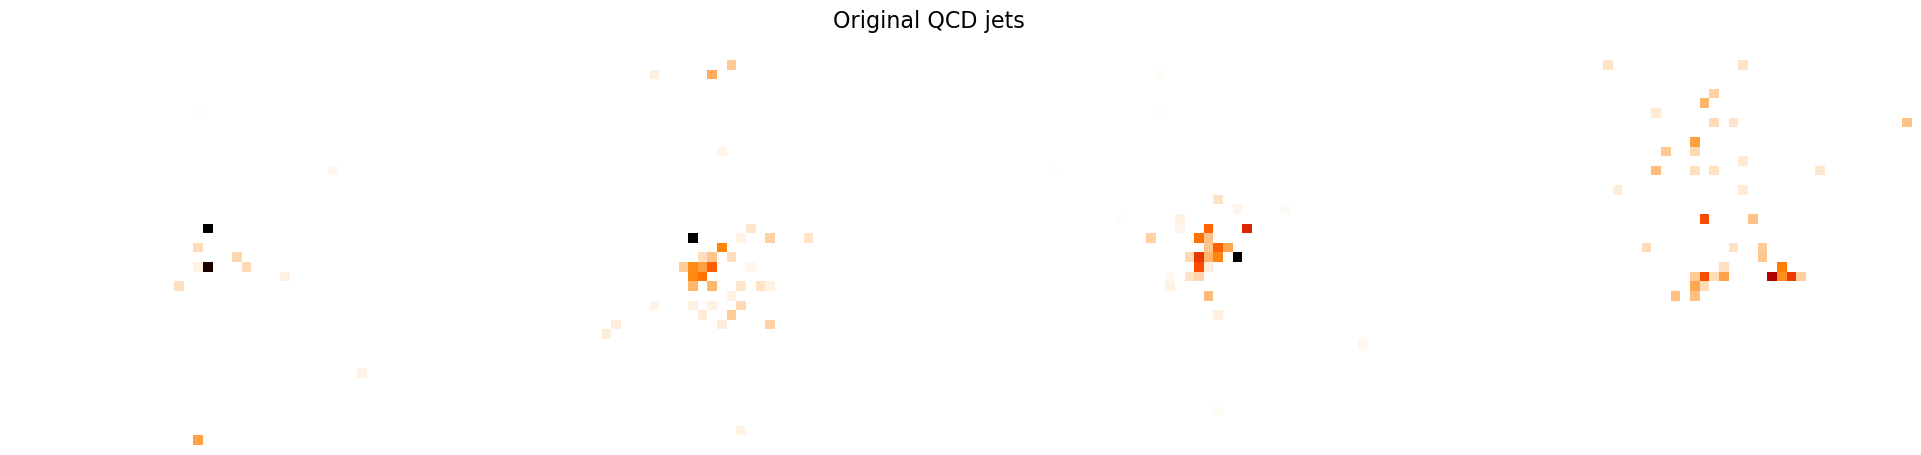

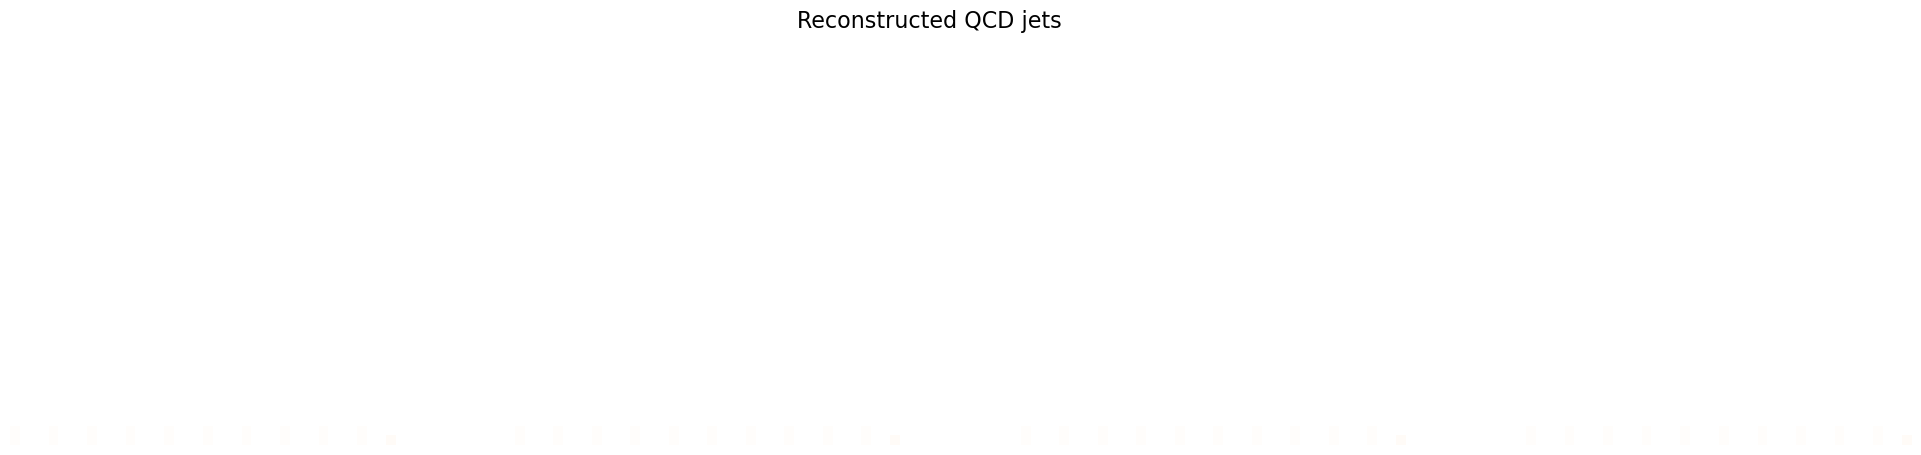

In [256]:
all_images = np.concatenate([top_jet_test, model2(torch.tensor(top_jet_test).float()).detach().numpy()])
vmin, vmax = all_images.min(), 0.2
def plot_images( images, n_images, title, vmin, vmax ):
    fig, axs = plt.subplots(1, n_images, figsize=(25, 5))
    for i in range(n_images):
        axs[i].imshow(images[i].squeeze(0), cmap="gist_heat_r", vmin=vmin, vmax=vmax)
        axs[i].axis("off")
    fig.suptitle(title, fontsize=16)
    plt.show()

plot_images(top_jet_test, 4, "Original top jets", 0, vmax)
plot_images(model2(torch.tensor(top_jet_test).float()).detach().numpy(), 4, "Reconstructed top jets", 0, vmax)
plot_images(qcd_jet_test, 4, "Original QCD jets", 0, vmax)
plot_images(model2(torch.tensor(qcd_jet_test).float()).detach().numpy(), 4, "Reconstructed QCD jets", 0, vmax)


Text(0.5, 0.98, 'Pixel-wise MSE')

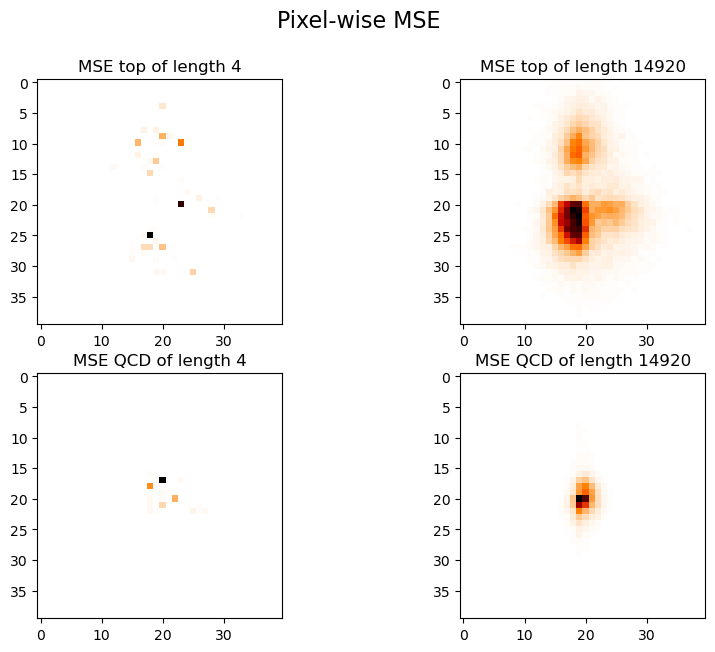

In [257]:
fig, axs = plt.subplots(2,2, figsize=(10,7))

length  = [4,len(top_jet_test)]
for i,j in enumerate(length):
    
    mse_top =np.square(top_jet_test[:j] - model2(torch.tensor(top_jet_test).float())[:j].detach().numpy()).mean(axis=0)
    mse_qcd =np.square(qcd_jet_test[:j] - model2(torch.tensor(qcd_jet_test).float())[:j].detach().numpy()).mean(axis=0)
    axs[0][i].imshow(mse_top.reshape(40,40), cmap="gist_heat_r")
    axs[0][i].set_title(f"MSE top of length {j}")
    axs[1][i].imshow(mse_qcd.reshape(40,40), cmap="gist_heat_r")
    axs[1][i].set_title(f"MSE QCD of length {j}")

#plt.hist(mse_top, bins=40, label="MSE top", alpha=0.5, range=(0,0.001))
#plt.hist(mse_qcd, bins=40, label="MSE QCD", alpha=0.5, range=(0,0.001))
#plt.legend()

fig.suptitle("Pixel-wise MSE", fontsize=16)

In [258]:
print(model2(torch.tensor(top_jet_test).float()).detach().numpy().shape)


(14920, 1, 40, 40)


In [259]:
print(top_jet_test.shape)
print(top_jet_test.squeeze(1).shape)
print(top_jet_test.reshape(len(top_jet_test),-1).shape)

torch.Size([14920, 1, 40, 40])
torch.Size([14920, 40, 40])
torch.Size([14920, 1600])


In [260]:
top_model = model2(torch.tensor(top_jet_test).float()).detach().numpy()
qcd_model = model2(torch.tensor(qcd_jet_test).float()).detach().numpy()
print(top_model.shape)

(14920, 1, 40, 40)


In [261]:
	

# calculate the MSE for all top and qcd jets image- wise on the test data set

mse_top =np.square(top_jet_test.reshape(len(top_jet_test),-1) - top_model.reshape(len(top_jet_test),-1)).mean(axis=1)
mse_qcd =np.square(qcd_jet_test.reshape(len(qcd_jet_test),-1) - qcd_model.reshape(len(qcd_jet_test),-1)).mean(axis=1)
mse_pred = np.concatenate([mse_top, mse_qcd])
print(mse_top.shape)

mse_top_labels = np.ones(mse_top.shape[0])
mse_qcd_labels = np.zeros(mse_qcd.shape[0])
mse_labels = np.concatenate([mse_top_labels, mse_qcd_labels])

torch.Size([14920])


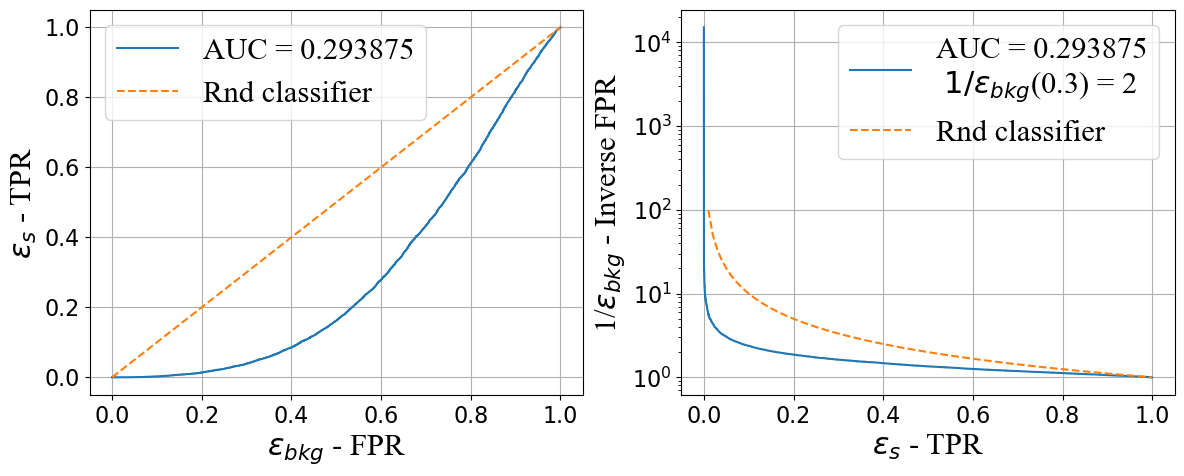

In [262]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve(mse_labels, mse_pred)
auc_score = roc_auc_score(mse_labels, mse_pred)
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.6f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.6f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR', fontproperties=axislabelfont)
ax[0].set_ylabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)

ax[1].set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
for i in range(len(ax)):
    ax[i].legend(prop=axislabelfont)
    ax[i].tick_params(labelsize=axisfontsize)
    ax[i].grid('on')

(f)

In [263]:
# TODO: Repeat everything for autoencoder trained on top jets
# You can either use a MLP or a CNN


In [264]:
#USing MLP

In [265]:
class Autoencoder(nn.Module):
    """Some Information about MyModule"""
    def __init__( self, data_dim, hiddenlayer_size, bottleneck_size ):
        super( Autoencoder, self ).__init__()
                
        self.enc_layer1 = nn.Linear( data_dim, hiddenlayer_size )
        self.enc_relu_1 = nn.ReLU()
        self.enc_layer2 = nn.Linear( hiddenlayer_size, hiddenlayer_size )
        self.enc_relu_2 = nn.ReLU()
        self.enc_layer3 = nn.Linear( hiddenlayer_size, bottleneck_size )
        
        self.dec_layer1 = nn.Linear( bottleneck_size, hiddenlayer_size )
        self.dec_relu_1 = nn.ReLU()
        self.dec_layer2 = nn.Linear( hiddenlayer_size, hiddenlayer_size )
        self.dec_relu_2 = nn.ReLU()
        self.dec_layer3 = nn.Linear( hiddenlayer_size, data_dim )

        
    def forward( self, batch ):

        x = self.encode( batch )
        x = self.decode( x )

        return x
    
    def encode( self, batch ):
        
        x = self.enc_layer1( batch )
        x = self.enc_relu_1( x )
        x = self.enc_layer2( x )
        x = self.enc_relu_2( x )
        x = self.enc_layer3( x )
        
        return x
    
    def decode( self, batch ):
        
        x = self.dec_layer1( batch )
        x = self.dec_relu_1( x )
        x = self.dec_layer2( x )
        x = self.dec_relu_2( x )
        x = self.dec_layer3( x )

        return x

In [266]:
class mlp_data( torch.utils.data.Dataset ):
    
    def __init__( self, imgs, labels ):
        self.imgs = imgs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

In [267]:
z_train_flattened = z_train.reshape( (z_train.shape[0],-1) )
z_test_flattened = z_test.reshape( (z_test.shape[0],-1) )
z_val_flattened = z_val.reshape( (z_val.shape[0],-1) )

z_train_torch = torch.Tensor(z_train_flattened).float()
z_test_torch = torch.Tensor(z_test_flattened).float()
z_val_torch = torch.Tensor(z_val_flattened).float()

# create datasets with only qcd and top jets where qcd is 0 and top is 1
qcd_jet_train = z_train_torch[y_train == 0]
qcd_jet_test = z_test_torch[y_test == 0]
qcd_jet_val = z_val_torch[y_val == 0]

top_jet_train = z_train_torch[y_train == 1]
top_jet_test = z_test_torch[y_test == 1]
top_jet_val = z_val_torch[y_val == 1]

train_cnn_top = mlp_data(top_jet_train, torch.zeros(top_jet_train.shape[0]).unsqueeze(-1))
test_cnn_top = mlp_data(top_jet_test, torch.zeros(top_jet_test.shape[0]).unsqueeze(-1))
val_cnn_top = mlp_data(top_jet_val, torch.zeros(top_jet_val.shape[0]).unsqueeze(-1))

trn_dataloader = torch.utils.data.DataLoader( train_cnn_top, batch_size=64, shuffle=True )
tst_dataloader = torch.utils.data.DataLoader( test_cnn_top, batch_size=64, shuffle=True )
val_dataloader = torch.utils.data.DataLoader( val_cnn_top, batch_size=64, shuffle=True )

In [268]:
def batch_loss(model, loss_fn, x):
    pred = model(x)
    loss = loss_fn(pred, x)
    return loss

In [269]:
def train_epoch(model, dataloader, loss_fn, losses, batch_loss_fn, optimizer):
    for x, y in dataloader:
        optimizer.zero_grad()
        loss = batch_loss_fn(model, loss_fn, x)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [270]:
def train_epoch(model, dataloader, loss_fn, losses, batch_loss_fn, optimizer):
    for x, y in dataloader:
        optimizer.zero_grad()
        loss = batch_loss_fn(model, loss_fn, x)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [271]:
n_epochs = 10
loss_fn = nn.MSELoss()

model3 = Autoencoder(1600, 400, 20)

model3_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
print(f"Model has {model3_params:d} trainable parameters")
learning_rate = 1e-3
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
for epoch in tqdm(range(n_epochs)):
    train_losses = train_epoch(model3, trn_dataloader, loss_fn, train_losses, batch_loss, optimizer)
    
    val_losses = val_epoch(model3, val_dataloader, loss_fn, val_losses, batch_loss)
    
    if epoch%1==0:
        print(f"{epoch} / {n_epochs}")
        print(f"train loss: {train_losses[-1]:.6f}")
        print(f"val loss: {val_losses[-1]:.6f}")

Model has 1619220 trainable parameters


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:11<01:40, 11.12s/it]

0 / 10
train loss: 0.000066
val loss: 0.000066


 20%|██        | 2/10 [00:21<01:27, 10.93s/it]

1 / 10
train loss: 0.000058
val loss: 0.000061


 30%|███       | 3/10 [00:34<01:20, 11.56s/it]

2 / 10
train loss: 0.000053
val loss: 0.000055


 40%|████      | 4/10 [00:50<01:20, 13.43s/it]

3 / 10
train loss: 0.000046
val loss: 0.000049


 50%|█████     | 5/10 [01:07<01:13, 14.74s/it]

4 / 10
train loss: 0.000046
val loss: 0.000045


 60%|██████    | 6/10 [01:26<01:04, 16.12s/it]

5 / 10
train loss: 0.000044
val loss: 0.000043


 70%|███████   | 7/10 [01:46<00:52, 17.51s/it]

6 / 10
train loss: 0.000047
val loss: 0.000042


 80%|████████  | 8/10 [02:08<00:37, 18.86s/it]

7 / 10
train loss: 0.000035
val loss: 0.000041


 90%|█████████ | 9/10 [02:28<00:19, 19.26s/it]

8 / 10
train loss: 0.000041
val loss: 0.000040


100%|██████████| 10/10 [02:49<00:00, 16.90s/it]

9 / 10
train loss: 0.000036
val loss: 0.000039


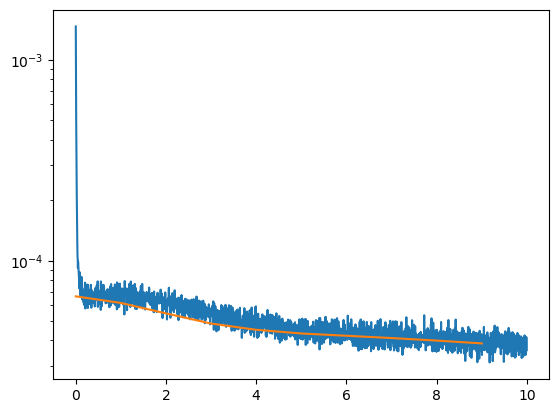

In [272]:
plt.plot(np.arange(len(train_losses)) / len(trn_dataloader), train_losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.yscale("log")
plt.show()

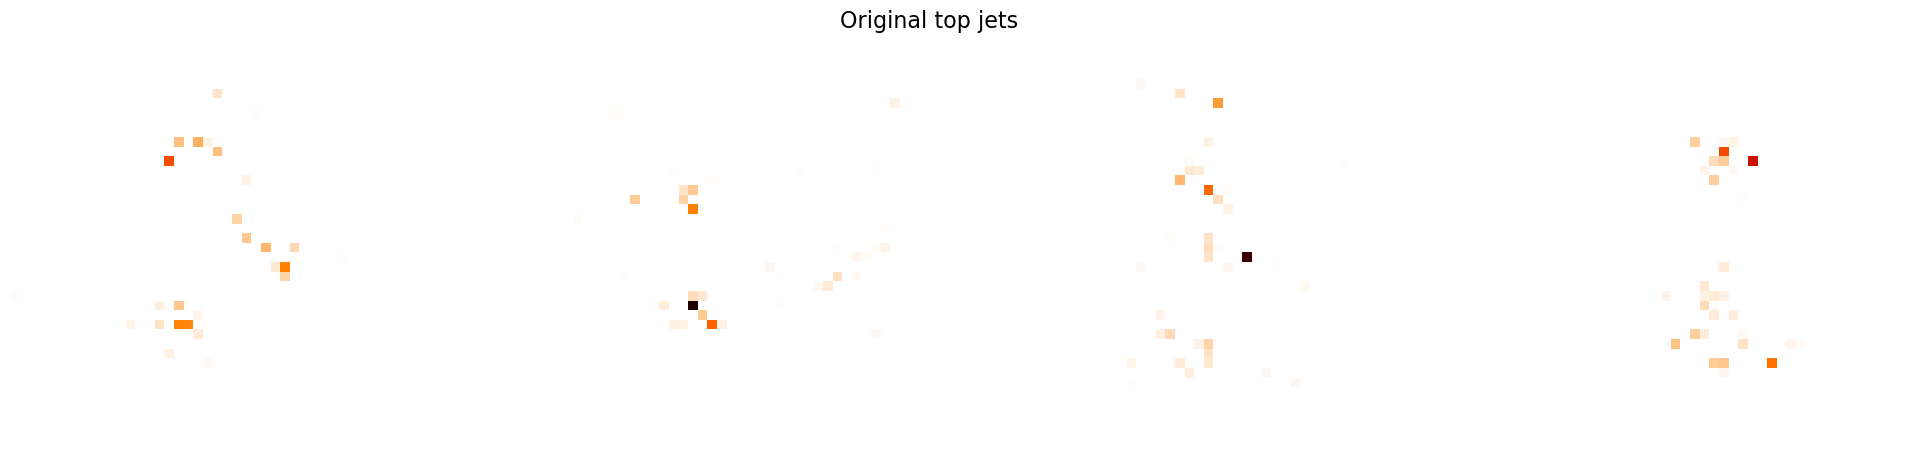

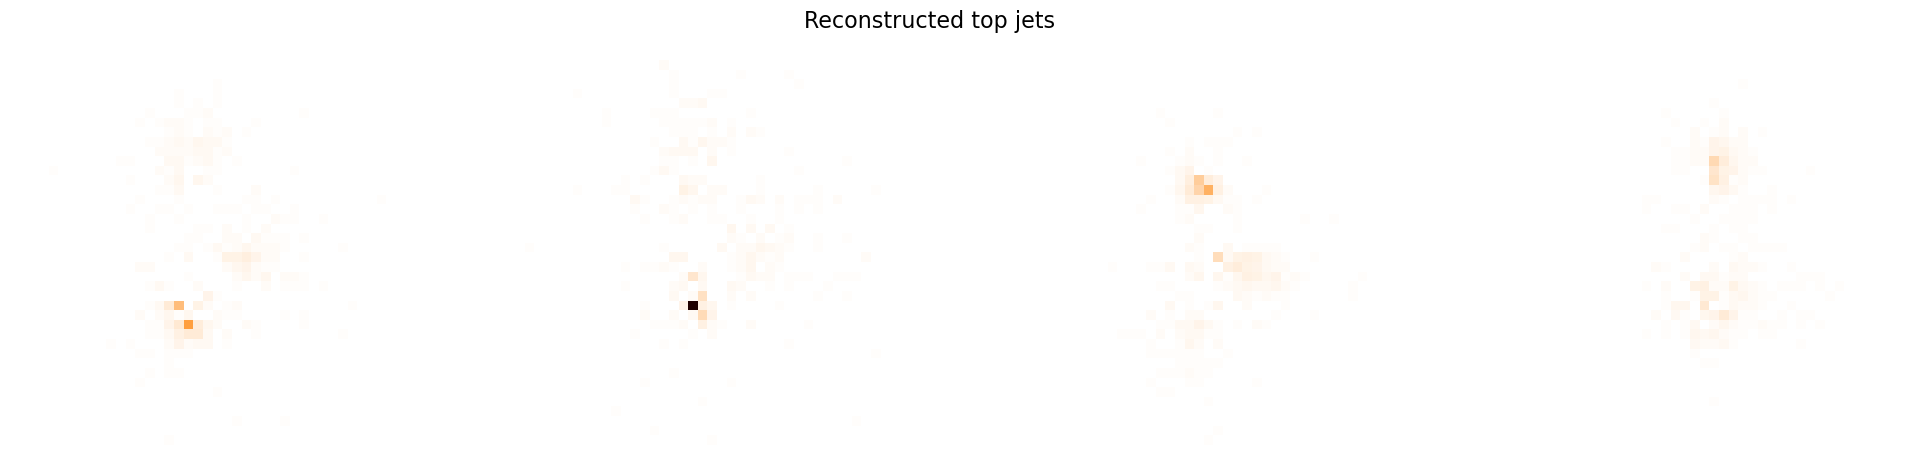

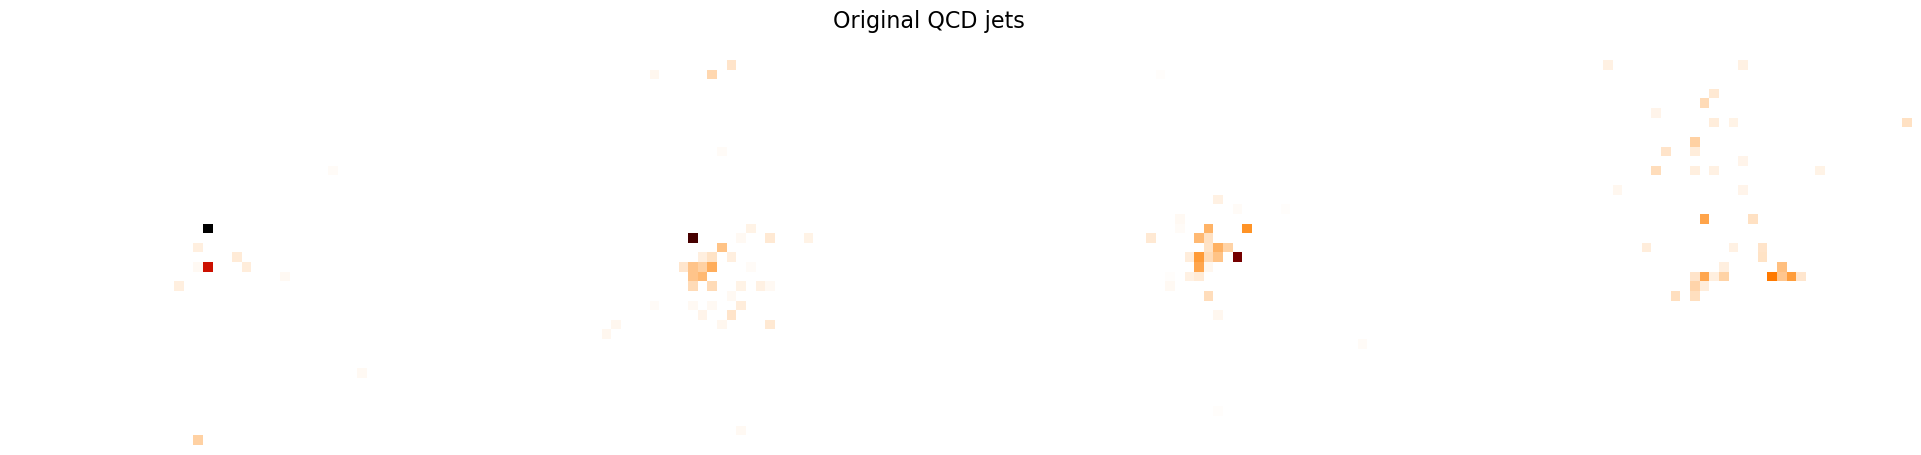

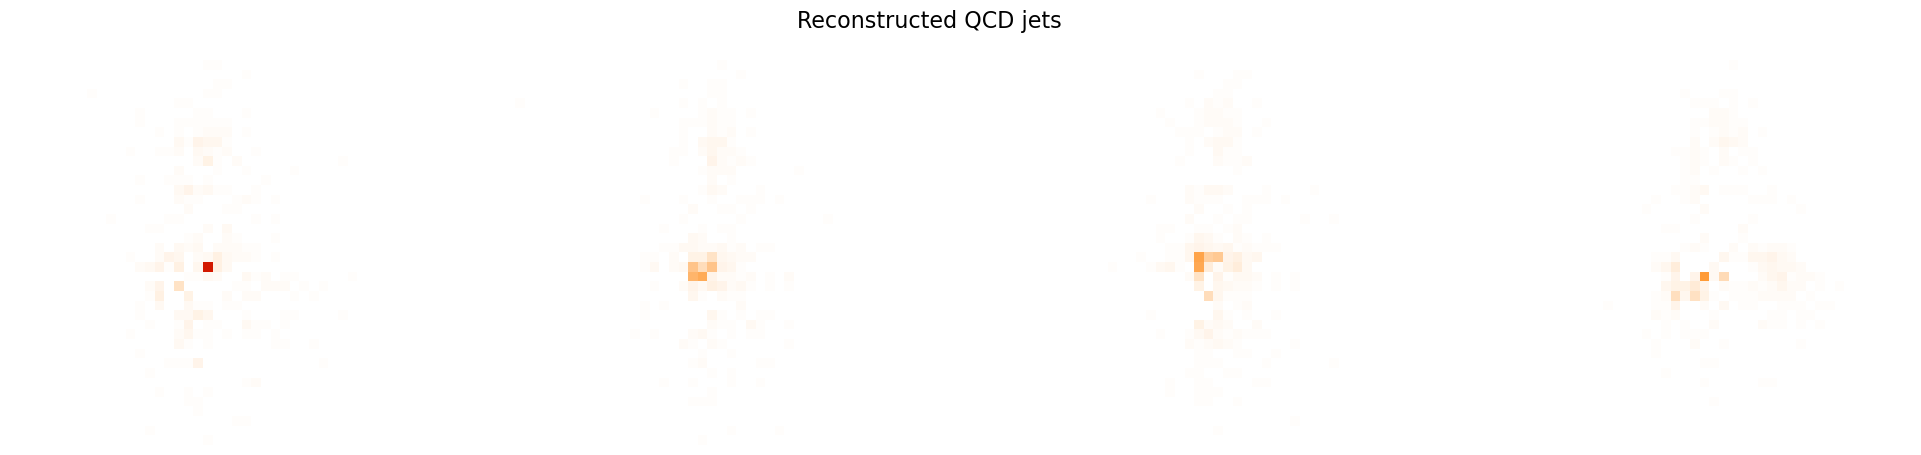

In [273]:
all_images = np.concatenate([top_jet_test, model3(torch.tensor(top_jet_test).float()).detach().numpy()])
vmin, vmax = all_images.min(), 0.4
def plot_images( images, n_images, title, vmin, vmax ):
    fig, axs = plt.subplots(1, n_images, figsize=(25, 5))
    for i in range(n_images):
        axs[i].imshow(images[i].reshape(40,40), cmap="gist_heat_r", vmin=vmin, vmax=vmax)
        axs[i].axis("off")
    fig.suptitle(title, fontsize=16)
    plt.show()

plot_images(top_jet_test, 4, "Original top jets", 0, vmax)
plot_images(model3(torch.tensor(top_jet_test).float()).detach().numpy(), 4, "Reconstructed top jets", 0, vmax)
plot_images(qcd_jet_test, 4, "Original QCD jets", 0, vmax)
plot_images(model3(torch.tensor(qcd_jet_test).float()).detach().numpy(), 4, "Reconstructed QCD jets", 0, vmax)

Text(0.5, 0.98, 'Pixel-wise MSE')

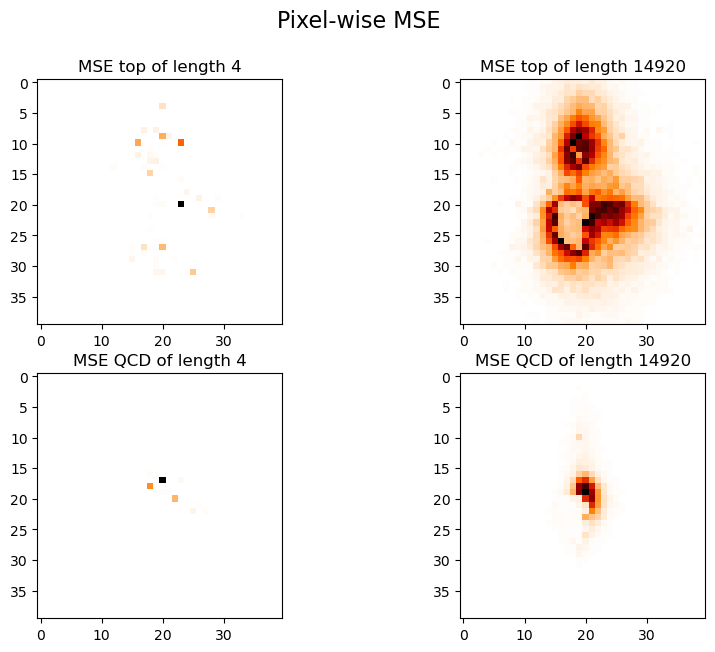

In [274]:
fig, axs = plt.subplots(2,2, figsize=(10,7))

length  = [4,len(top_jet_test)]
for i,j in enumerate(length):
    
    mse_top =np.square(top_jet_test[:j] - model3(torch.tensor(top_jet_test).float())[:j].detach().numpy()).mean(axis=0)
    mse_qcd =np.square(qcd_jet_test[:j] - model3(torch.tensor(qcd_jet_test).float())[:j].detach().numpy()).mean(axis=0)
    axs[0][i].imshow(mse_top.reshape(40,40), cmap="gist_heat_r")
    axs[0][i].set_title(f"MSE top of length {j}")
    axs[1][i].imshow(mse_qcd.reshape(40,40), cmap="gist_heat_r")
    axs[1][i].set_title(f"MSE QCD of length {j}")

#plt.hist(mse_top, bins=40, label="MSE top", alpha=0.5, range=(0,0.001))
#plt.hist(mse_qcd, bins=40, label="MSE QCD", alpha=0.5, range=(0,0.001))
#plt.legend()

fig.suptitle("Pixel-wise MSE", fontsize=16)


In [275]:
mse_top =np.square(top_jet_test - model3(torch.tensor(top_jet_test).float()).detach().numpy()).mean(axis=1)
mse_qcd =np.square(qcd_jet_test - model3(torch.tensor(qcd_jet_test).float()).detach().numpy()).mean(axis=1)
mse_pred = np.concatenate([mse_top, mse_qcd])
print(mse_top.shape)

mse_top_labels = np.ones(mse_top.shape[0])
mse_qcd_labels = np.zeros(mse_qcd.shape[0])
mse_labels = np.concatenate([mse_top_labels, mse_qcd_labels])

torch.Size([14920])


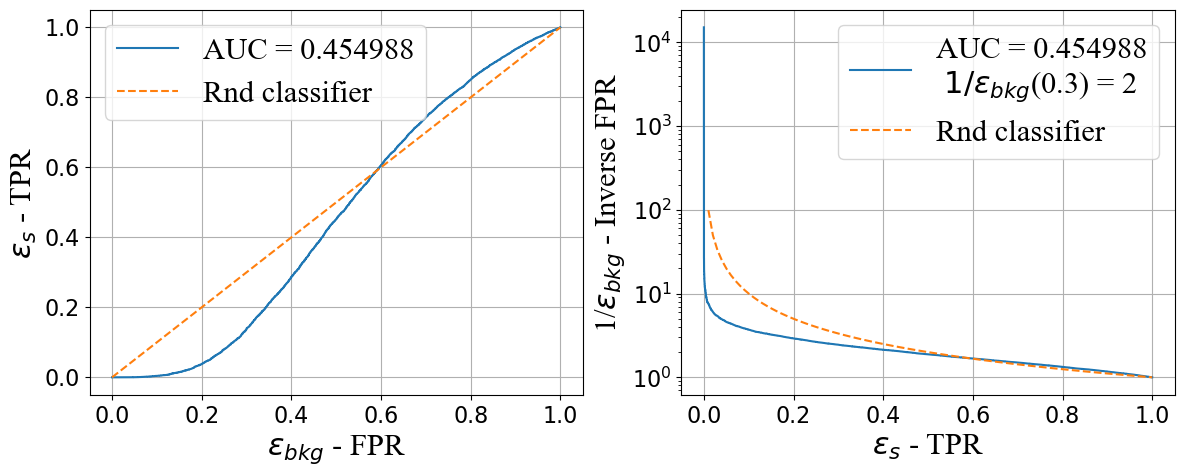

In [276]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve(mse_labels, mse_pred)
auc_score = roc_auc_score(mse_labels, mse_pred)
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.6f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.6f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR', fontproperties=axislabelfont)
ax[0].set_ylabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)

ax[1].set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
for i in range(len(ax)):
    ax[i].legend(prop=axislabelfont)
    ax[i].tick_params(labelsize=axisfontsize)
    ax[i].grid('on')